In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip /content/drive/MyDrive/Computer_Vision/CelebA-HQ-img-20000.zip

Archive:  /content/drive/MyDrive/Computer_Vision/CelebA-HQ-img-20000.zip
replace CelebA-HQ-img-20000/9733.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!unzip /content/drive/MyDrive/Computer_Vision/CelebA-HQ-mask-20000.zip

Archive:  /content/drive/MyDrive/Computer_Vision/CelebA-HQ-mask-20000.zip
replace CelebA-HQ-mask-20000/00267_hair.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
# Set Paths
IMAGE_DIR = "/content/CelebA-HQ-img-20000"
MASK_DIR = "/content/CelebA-HQ-mask-20000"

# Image and Mask Dimensions
IMG_HEIGHT = 256
IMG_WIDTH = 256
NUM_CLASSES = 2  # Number of segmentation classes (e.g., skin, hair, eyes, etc.)

In [ ]:

import re

def extract_number(filename):
  """
  Extracts the number from a filename like "0.jpg".

  Args:
    filename: The filename string.

  Returns:
    The extracted number as an integer, or None if no number is found.
  """
  match = re.search(r"(\d+)", filename)
  if match:
    return int(match.group(1))
  return None

# Example usage
filename = "0.jpg"
number = extract_number(filename)
if number is not None:
    print(f"The number extracted from '{filename}' is: {number}")
else:
    print(f"No number found in '{filename}'")

The number extracted from '0.jpg' is: 0


In [ ]:
# prompt: how to load model from path /content/drive/MyDrive/Computer_Vision/best_model.h5

from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/Computer_Vision/best_model_20000.h5')


In [ ]:

def load_data(image_dir, mask_dir, batch_size=32, test_data=False, test_size=0.2, random_state=42):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Split into train and test sets if requested
    if test_data:
      _, test_image_files, _, test_mask_files = train_test_split(
          image_files, mask_files, test_size=test_size, random_state=random_state
      )
      image_files = test_image_files
      mask_files = test_mask_files

    num_samples = len(image_files)

    for i in range(0, num_samples, batch_size):
        batch_images, batch_masks = [], []
        for j in range(i, min(i + batch_size, num_samples)):
            img_name = image_files[j]

            # Extract image number and construct mask filename
            filenumber = extract_number(img_name)
            image_number = str(filenumber).zfill(5)
            mask_name = image_number + "_hair.png"

            img_path = os.path.join(image_dir, img_name)
            mask_path = os.path.join(mask_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f"Mask file not found for image: {image_number}")
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"Error reading image: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
            img = img / 255.0  # Normalize

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                print(f"Error reading mask: {mask_path}")
                continue
            mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
            mask = (mask / 255 * (NUM_CLASSES - 1)).astype(np.uint8)
            mask = to_categorical(mask, NUM_CLASSES)

            batch_images.append(img)
            batch_masks.append(mask)

        yield np.array(batch_images), np.array(batch_masks)



In [ ]:
# Get test data in batches
test_batch_size = 8 # Set batch size for test data
test_data_generator = load_data(IMAGE_DIR, MASK_DIR, batch_size=test_batch_size,test_data=True)




1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step


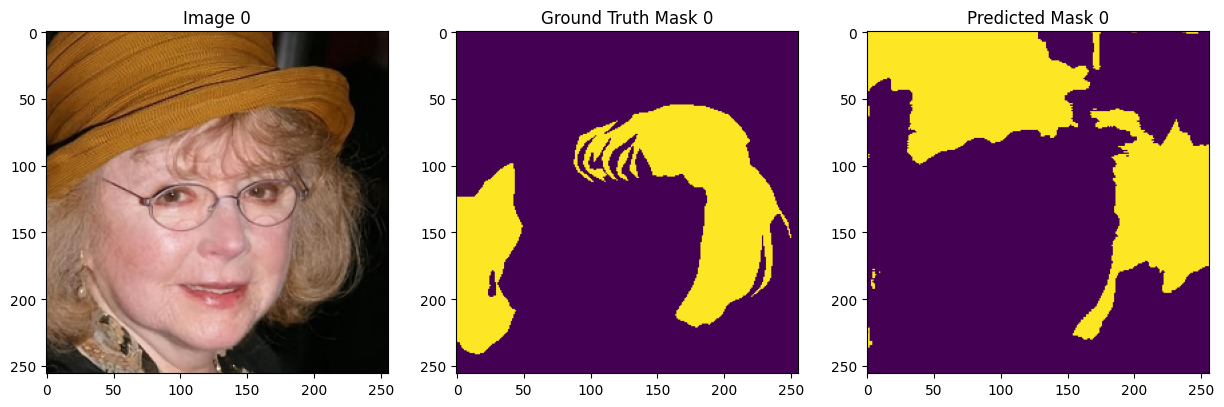

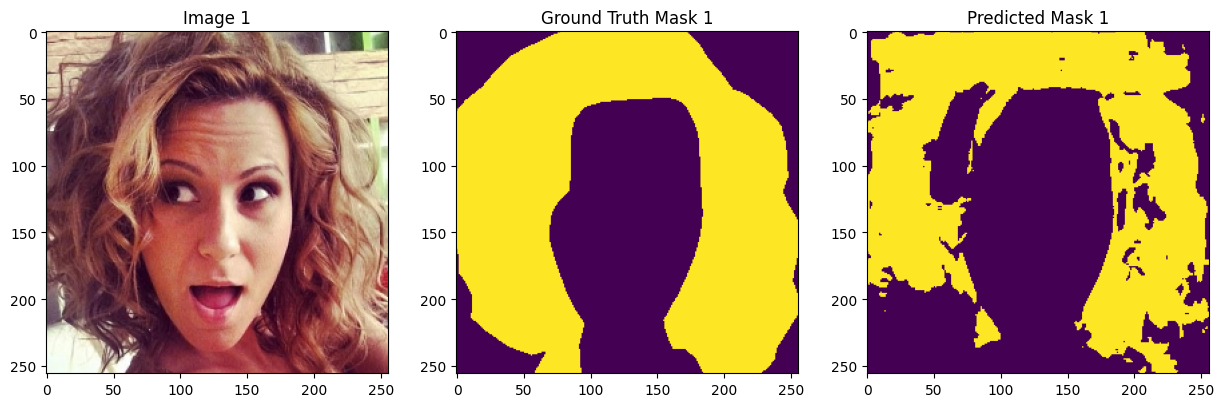

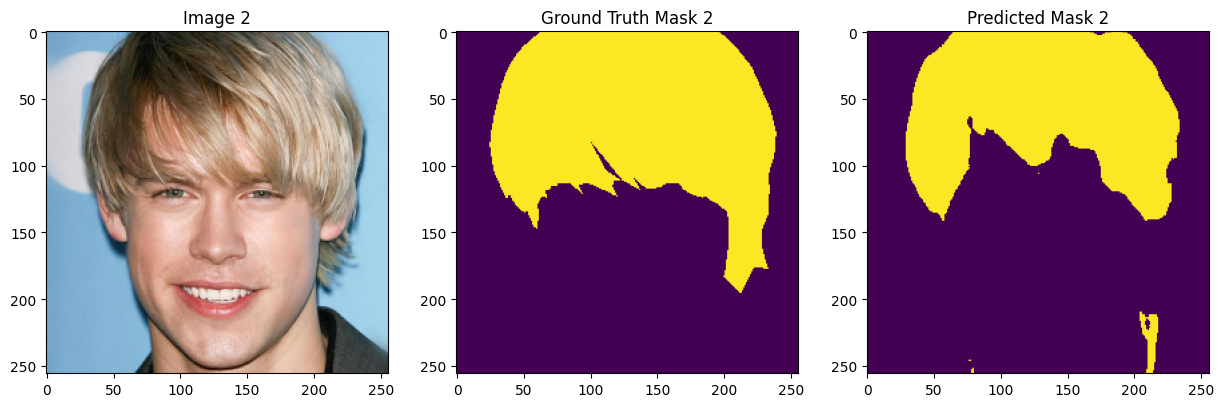

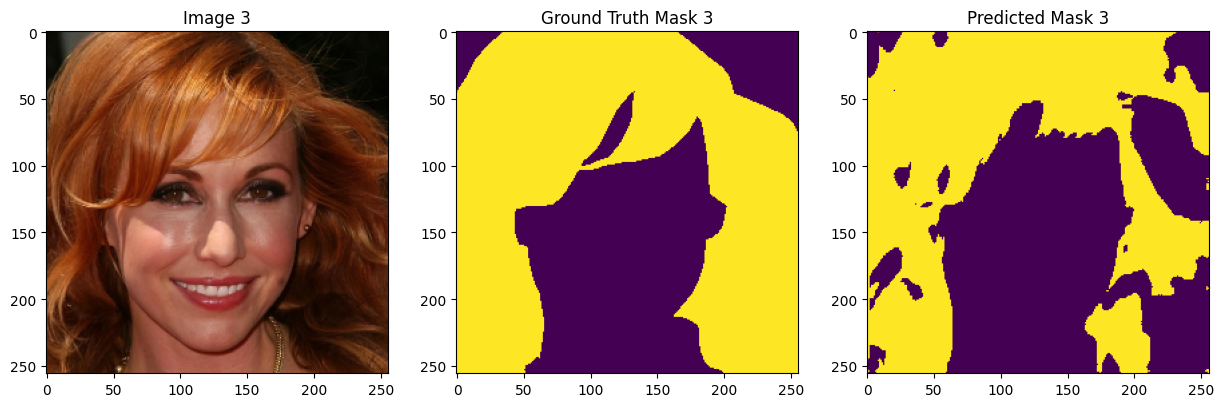

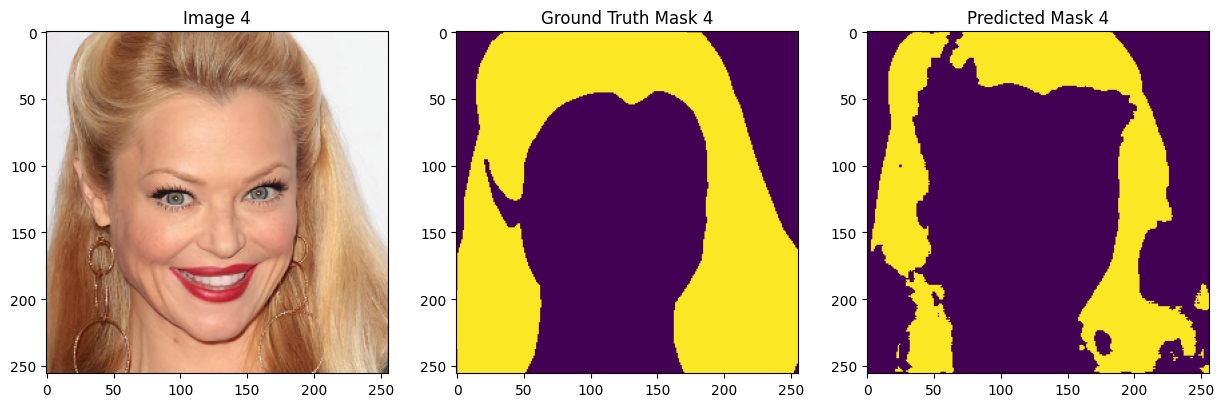

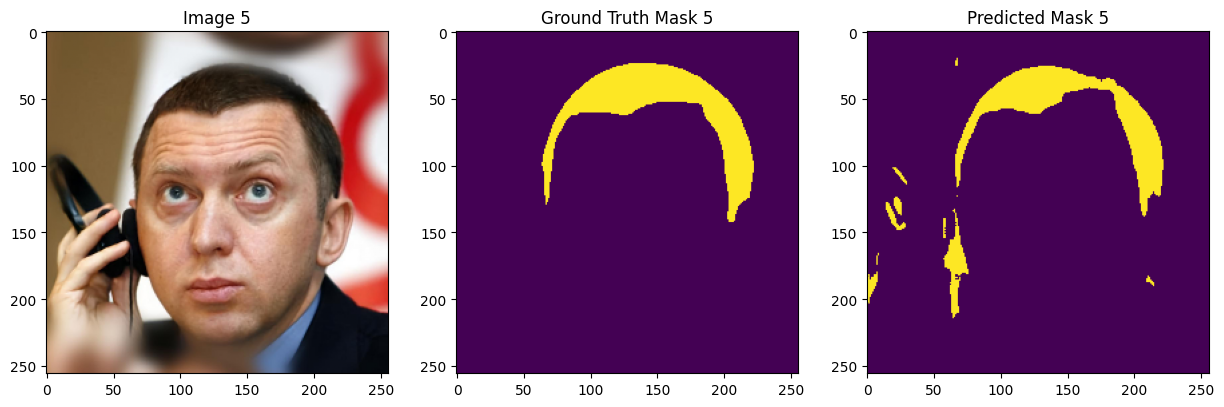

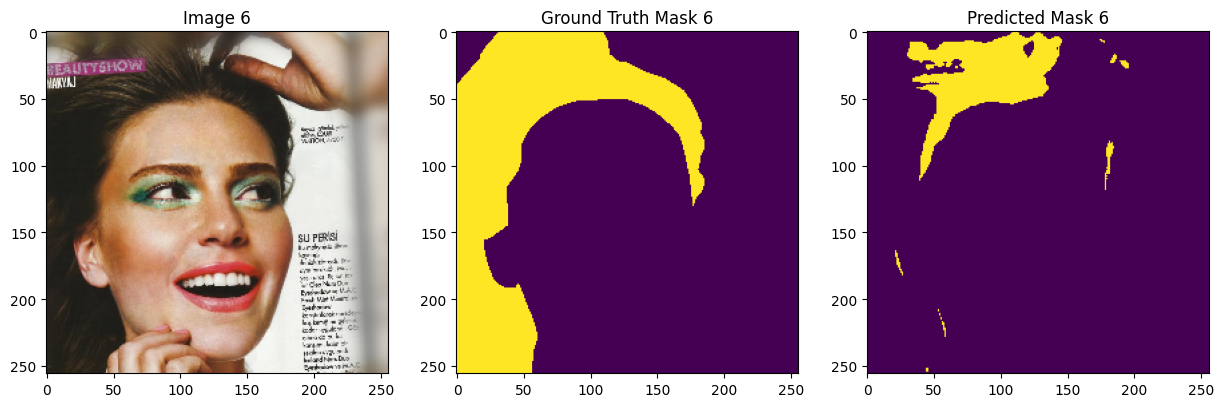

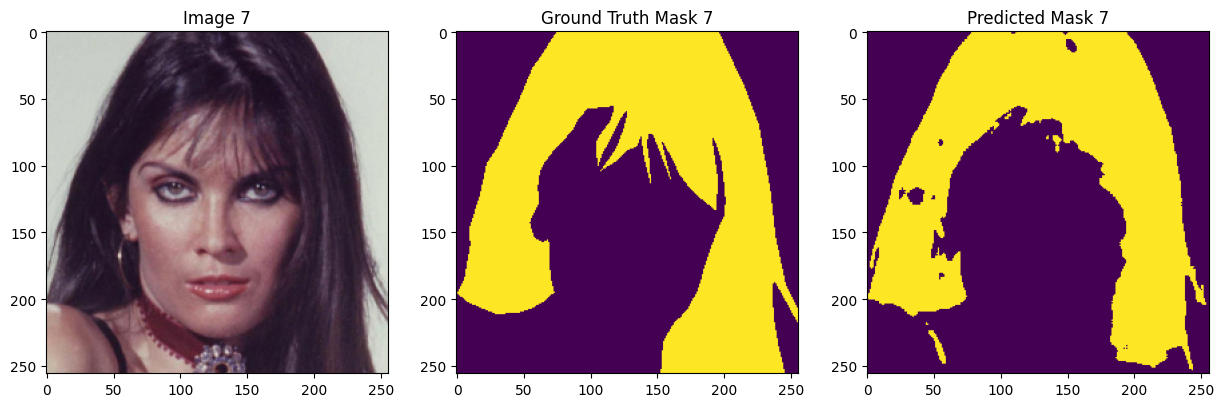

In [ ]:

for batch_images, batch_masks in test_data_generator:
  # Make predictions here using model.predict(batch_images)
  predictions = model.predict(batch_images)

  # Process predictions and masks
  for i in range(len(batch_images)):
      plt.figure(figsize=(15, 5))

      plt.subplot(1, 3, 1)
      plt.imshow(batch_images[i])
      plt.title(f"Image {i}")

      plt.subplot(1, 3, 2)
      plt.imshow(np.argmax(batch_masks[i], axis=-1)) # Display the class index
      plt.title(f"Ground Truth Mask {i}")

      plt.subplot(1, 3, 3)
      plt.imshow(np.argmax(predictions[i], axis=-1))
      plt.title(f"Predicted Mask {i}")

      plt.show()
  break #remove this when you want to process the whole test dataset


In [ ]:
test_batch_size = 16 # Set batch size for test data
test_data_generator = load_data(IMAGE_DIR, MASK_DIR, batch_size=test_batch_size,test_data=True)

In [ ]:
# prompt: How to calculate accuracy of predicted and actual masks

from sklearn.metrics import accuracy_score

# ... (Your existing code)

# Initialize lists to store flattened predictions and true masks
all_true_masks = []
all_predicted_masks = []
count=0
# Iterate and make predictions for test data
for batch_images, batch_masks in test_data_generator:
    count=count+1
    if(count>20):
      break;
    # Make predictions here using model.predict(batch_images)
    predictions = model.predict(batch_images)

    # Flatten the true masks and predictions for each image in the batch
    for i in range(len(batch_images)):
        true_mask = np.argmax(batch_masks[i], axis=-1).flatten()
        predicted_mask = np.argmax(predictions[i], axis=-1).flatten()

        all_true_masks.extend(true_mask)
        all_predicted_masks.extend(predicted_mask)

    # Stop after processing a certain number of batches (optional)
    # Remove this break if you want to evaluate the whole test set
    #break

# Calculate the overall accuracy
accuracy = accuracy_score(all_true_masks, all_predicted_masks)
print(f"Overall Accuracy: {accuracy}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 32s 32s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 29s 29s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step
Overall Accuracy: 0.9071011066436767


**Business Problem**

*   Virtual try ons for spectacles, jewellery, hats etc
*   Face editing & generation for new looks
*   Face Segmentation of analysis facial expressions can identify neurological disorders

**Dataset**

*   CelebAMask-HQ standard dataset for face segmentation
*   30K high resolution images of 512 x 512 resolution
*   19 classes

**Model Used**
U-Net Architecture with 3 encoders and 3 decoders
Encoder-Decoder architecture with skip connections makes it suitable for face segmentation

**Use Cases**
*   Virtual Try Ons
*   Face regeneration & edits


















Progress made
1) Trained on more data
2) Achieved higher accuracy

Roadblocks
1) Large dataset
2) High computational resources required to train & evaluate
3) Notebook crashed due to out of memory issues multiple times